## 목표
- 타이타닉 데이터를 학습하여 생존자/사망자를 예측해보자
- 머신러닝 전체 과정을 숙지해보자

### 1. 문제 정의
- 생존자/사망자를 예측해보자
- kaggle에서 높은 순위

### 2. 데이터 수집
- kaggle 에서 제공하는 train 데이터와 test 데이터 사용

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train = pd.read_csv('./data/train.csv', index_col='PassengerId')
test = pd.read_csv('./data/test.csv', index_col='PassengerId')

In [3]:
# 크기확인
print('훈련 데이터 크기 : ',train.shape) # 컬럼에 생존 여부 있음 (11)
print('테스트 데이터 크기 : ',test.shape) # 컬럼에 생존 여부 없음 (10)

훈련 데이터 크기 :  (891, 11)
테스트 데이터 크기 :  (418, 10)


### 3. 데이터 전처리 및 데이터 탐색 (EDA)

In [4]:
train.info() # 답 데이터 Survived, 결측치 Age, Cabin, Embarked
print()
print()
test.info() # 결측치 Age, Fare, Cabin

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


<class 'pandas.core.frame.DataFrame'>
Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       332 non-null   

In [5]:
train.columns

# 'Survived', 생존/사망 결과 값이 당긴 컬럼 (0:사망, 1:생존)
# 'Pclass', 승객 등급(1:상위층, 2:중상위층, 3:하위층)
# 'Name', 
# 'Sex', 
# 'Age', 
# 'SibSp', 형제자매/배우자의 수 (같이 탑승한) 
# 'Parch', 부모/자식의 수 (같이 탑승한)
# 'Ticket', 티켓 번호
# 'Fare', 요금
# 'Cabin', 객실 번호
# 'Embarked' 승선항(S, C, Q)

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked'],
      dtype='object')

- train : Embarked 컬럼 결측치 채우기

In [6]:
# 데이터 확인을 할 땐 항상 train데이터를 기준으로 확인
# train 데이터에서 Embarked 컬럼 인덱싱 -> S, C, Q 갯수 확인
print(train['Embarked'].value_counts(dropna=False))
# 결측치 채우기
train[train['Embarked'].isnull()]

Embarked
S      644
C      168
Q       77
NaN      2
Name: count, dtype: int64


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [7]:
# 두 사람의 데이터가 서로 비슷한데, 티켓의 번호까지 같다.
# 분명 전산 상의 오류가 있었던 것으로 판단이 된다.
# 전산 상의 오류가 있으려면 아무래도 사람이 많이 몰리는 항구인 S 항구에서 탔을 가능성이 높다.
train['Embarked'] = train['Embarked'].fillna('S')
train['Embarked'].value_counts(dropna=False)

Embarked
S    646
C    168
Q     77
Name: count, dtype: int64

- test : Fare 컬럼 결측치 채우기

In [8]:
# test 데이터의 Fare 컬럼 인덱싱 후 결측치가 존재하는 행 찾아보기
print(test[test['Fare'].isnull()])
# Pclass와 Sex이 연관성이 높을 것이다...
# 추측보단 신뢰성 있는 근거를 사용하자
train.corr(numeric_only=True) # corr = correlation 상관관계
# Fare 컬럼과 가장 연관성이 깊은 컬럼은 Pclass

             Pclass                Name   Sex   Age  SibSp  Parch Ticket  \
PassengerId                                                                
1044              3  Storey, Mr. Thomas  male  60.5      0      0   3701   

             Fare Cabin Embarked  
PassengerId                       
1044          NaN   NaN        S  


,Survived,Pclass,Age,SibSp,Parch,Fare
Survived,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


In [9]:
# train Fare 컬럼을 대표하는 수가 뭔지 찾아보자
# describe() # 수치 데이터(min, max, mean ...)
train['Fare'].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

In [10]:
# Pclass, Sex -> Fare 중앙 값으로 결측치를 대체해보자
# train 데이터를 기준으로 승객 등급, 성별을 그룹핑
train[['Pclass', 'Sex', 'Fare']].groupby(by=['Pclass', 'Sex']).median()

Fare
Pclass Sex             
1      female  82.66455
       male    41.26250
2      female  22.00000
       male    13.00000
3      female  12.47500
       male     7.92500

In [11]:
# test['Fare'] 결측치 채워주기
test[test['Fare'].isnull()] # 3등급 남성의 중앙값으로 채우기
test['Fare'] = test['Fare'].fillna(7.92500)
test['Fare'].isnull().sum()

0

- Age 결측치 채우기
    -train, test 모두 처리해야할 필요
    - 나이의 평균값? 중앙값? 최빈값? 으로 결측치 채워보기
    - 다른 컬럼과 상관관계를 이용해서 결측치 채우기


In [12]:
train['Age'].isnull().sum()
train.corr(numeric_only=True) # => Pclass Fare

,Survived,Pclass,Age,SibSp,Parch,Fare
Survived,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


In [13]:
train['Age'].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

In [14]:
train[train['Age'].isnull()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C
27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C
29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q
...,...,...,...,...,...,...,...,...,...,...,...
860,0,3,"Razi, Mr. Raihed",male,NaN,0,0,2629,7.2292,NaN,C
864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.5500,NaN,S
869,0,3,"van Melkebeke, Mr. Philemon",male,NaN,0,0,345777,9.5000,NaN,S


In [15]:
gb1 = train[['Pclass', 'Age', 'Sex']].groupby(by=['Pclass', 'Sex']).mean()
gb1

Age
Pclass Sex              
1      female  34.611765
       male    41.281386
2      female  28.722973
       male    30.740707
3      female  21.750000
       male    26.507589

In [16]:
# 결측치가 많아서 승객의 등급과 성별을 구분하지 않으면 fillna()로 채울 수 없다.
train['Age'].isnull().sum()

177

In [17]:
# 멀티인덱스의 인덱싱
gb1.loc[(1, 'male')]

Age    41.281386
Name: (1, male), dtype: float64

In [18]:
# 사용자 정의 함수를 만들어보자
# 결측치를 채우기 위해서 각 승객의 등급과 성별을 확인한 후
# Age의 평균값을 인덱싱해서 채우는 함수가 필요하다
def prepro_age(row):
    if np.isnan(row['Age']):   # 만약, 나이가 결측치하면 값을 가져오고
        return gb1.loc[(row['Pclass'], row['Sex'])]
    else:       # 아니라면 원래 나이값을 그대로 사용하자
        return row['Age']

In [19]:
train['Age'] = train.apply(prepro_age, axis=1)
test['Age'] = test.apply(prepro_age, axis=1)

print(train['Age'].isnull().sum())
print(test['Age'].isnull().sum())

0
0


In [20]:
# 멀티인덱스 인덱싱을 사용하면 기존 데이터 타입을 파괴하는 현상이 종종 일어난다..
train['Age'] = train['Age'].astype('int64')
test['Age'] = test['Age'].astype('int64')

C:\Users\smhrd\AppData\Local\Temp\ipykernel_12160\1207155625.py:2: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  train['Age'] = train['Age'].astype('int64')
C:\Users\smhrd\AppData\Local\Temp\ipykernel_12160\1207155625.py:3: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  test['Age'] = test['Age'].astype('int64')


- train, test : Cabin(객실 번호) 채우기

In [21]:
train['Cabin'].isnull().sum()

687

In [22]:
train[train['Cabin'].isnull()]
train['Cabin'].unique()

# 결측치와 층수 및 생존과 상관관계를 알아보기 위해 결측치를 임의의 값으로 채워줘야 한다.
# 'M' 값으로 채워보기
train['Deck'] = train['Cabin'].fillna('M')
test['Deck'] = test['Cabin'].fillna('M')

In [23]:
train['Deck'] # 컬럼의 맨 첫글자 알파벳만 추출하기
train['Deck'] = train['Deck'].str[0]
test['Deck'] = test['Deck'].str[0]

In [24]:
try:
    train.drop('Cabin', axis=1, inplace=True)
    test.drop('Cabin', axis=1, inplace=True)
except:
    pass

In [25]:
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       891 non-null    int64  
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Embarked  891 non-null    object 
 10  Deck      891 non-null    object 
dtypes: float64(1), int64(5), object(5)
memory usage: 83.5+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       418 non-null    i

### 데이터 탐색

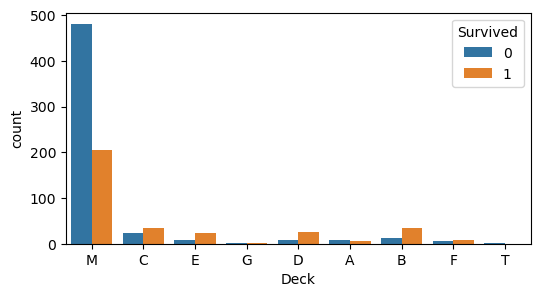

In [26]:
# 'M' - Deck
# Deck와 Survived 컬럼의 연관성 확인하기
# 막대그래프
plt.figure(figsize=(6, 3))
sns.countplot(data=train, x='Deck', hue='Survived')
plt.show()
# M에서 상대적으로 사람들이 많이 사망했다.
# -> 생존율에 영향을 주었을지는 의문

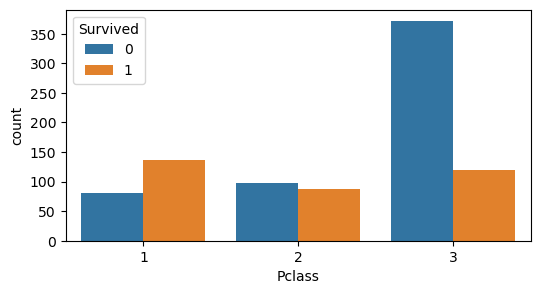

In [27]:
# Pclass와 Survived 관계 시각화
# countplot
plt.figure(figsize=(6, 3))
sns.countplot(data=train, x='Pclass', hue='Survived')
plt.show()
# 1등급 - 비교적 생존율이 높았다, 3등급 - 사망율이 월등히 높았다

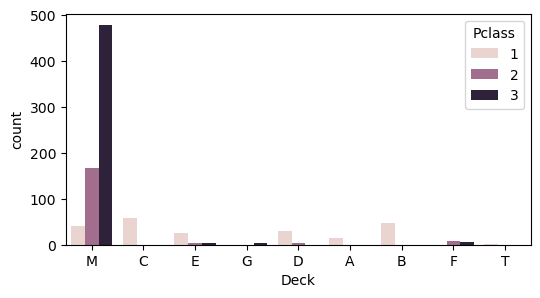

In [28]:
# Deck와 Pclass 관계 시각화
plt.figure(figsize=(6, 3))
sns.countplot(data=train, x='Deck', hue='Pclass')
plt.show()
# M에서 사망율이 높았던 건 3등급 객실의 사람들이 많아서였다.
# 그떄 당시 시대상으로 볼 때, 3등급 객실에 탄 사람들에게 궅이 객실 번호를 묻지 않았을 것이다.
# Deck는 Survived보다는 Pclass와 연관성이 높은 것으로 보인다.

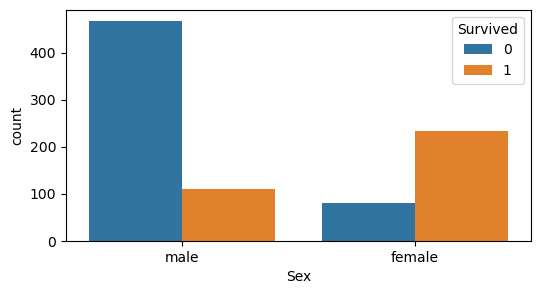

In [29]:
# Sex와 Survived 관계 시각화
plt.figure(figsize=(6, 3))
sns.countplot(data=train, x='Sex', hue='Survived')
plt.show()
# 남성은 상대적으로 사망율이 높고 여성은 생존율이 높다
# -> 생/사를 판별하는데 도움이 될 수 있다.

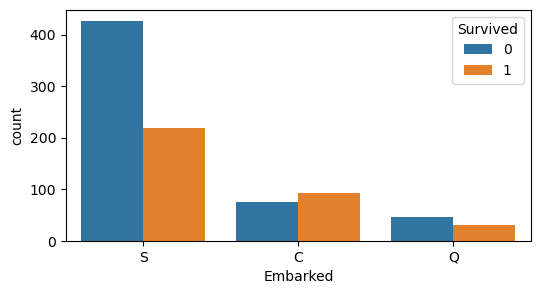

In [30]:
# Embarked와 Survived 관계 시각화
plt.figure(figsize=(6, 3))
sns.countplot(data=train, x='Embarked', hue='Survived')
plt.show()
# 승선항이 생/사에 크게 영향을 주진 않았다

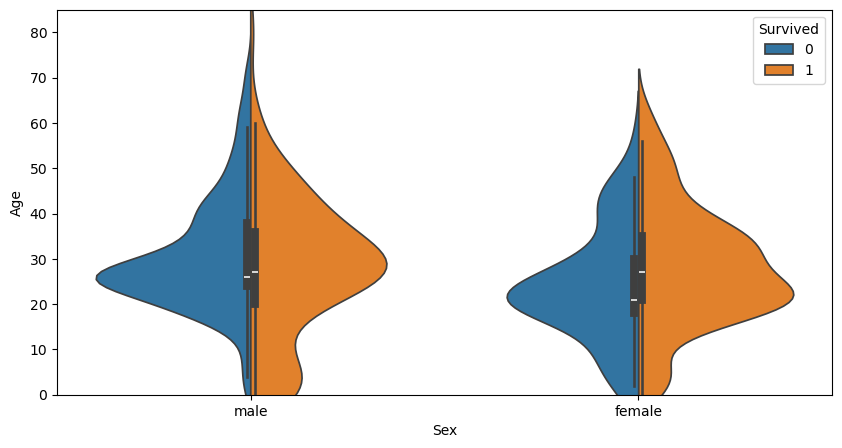

In [31]:
# Age와 Survived 관계 시각화
# violin plot -> 데이터의 분포를 확인할 때
plt.figure(figsize=(10, 5))
sns.violinplot(data=train, x='Sex', y='Age', hue='Survived', split=True)
plt.ylim(0, 85)
plt.show()
# 20대에서 40대에 걸쳐 남자는 사망율이 높았다.
# 20대 ~ 30대에 걸쳐 여자는 사망율이 높았다.
# 상대적으로 남자 영유아가 생존이 높았다.

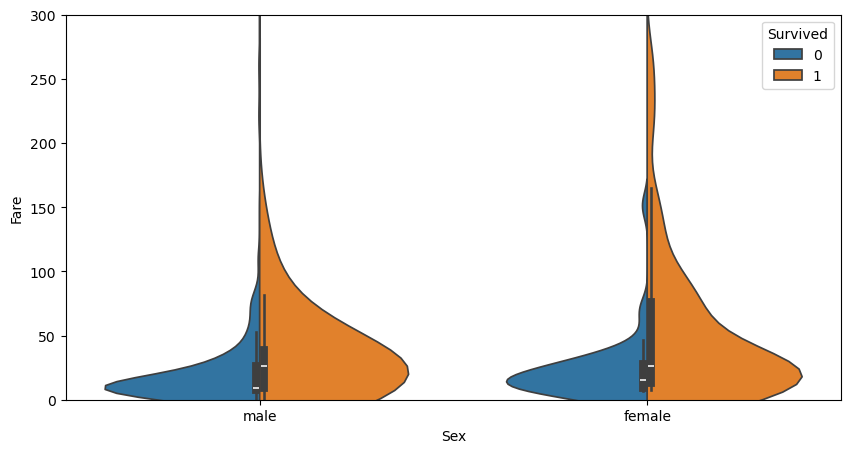

In [32]:
plt.figure(figsize=(10, 5))
sns.violinplot(data=train, x='Sex', y='Fare', hue='Survived', split=True)
plt.ylim(0, 300)
plt.show()
# 저렴한 요금을 내고 탄 사람들은 상대적으로 많이 사망했다.
# 요금을 많이 내고 탄 사람들은 거의 생존했다.

- Parch, Sibsp
    - 특성공학 : 두 개의 컬럼을 더해서 가족의 숫자라는 새로운 컬럼을 생성하는 것이 좋아 보인다.
    - train에 적용하고 test에 그대로 적용

In [33]:
train['Family_size'] = train['Parch'] + train['SibSp'] + 1
test['Family_size'] = test['Parch'] + test['SibSp'] + 1

(891,)
(891,)
(891,)


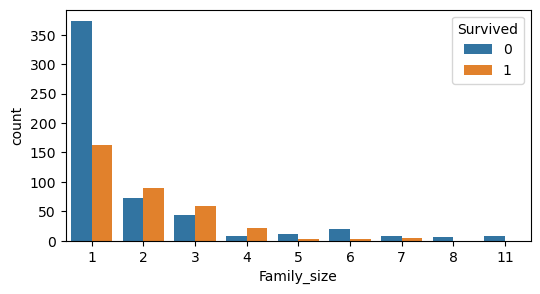

In [34]:
print(train['SibSp'].shape)
print(train['Parch'].shape)
print(train['Family_size'].shape)

plt.figure(figsize=(6, 3))
sns.countplot(data=train, x='Family_size', hue='Survived')
plt.show()
# 1명 -> 사망율이 높다
# 2~4명 -> 생존율이 높다
# 5명 이상 -> 사망율이 높다
# 범주를 줄여주자 == 카테고리화 하자

In [35]:
# 가족의 사이즈가 1명이면 Alone, 2~4명 Small, 5이상 Large
bins = [0, 1, 4, 11]
labels = ['Alone', 'Small', 'Large']
train['Family_group'] = pd.cut(train['Family_size'], bins = bins, labels = labels)
test['Family_group'] = pd.cut(test['Family_size'], bins = bins, labels = labels)

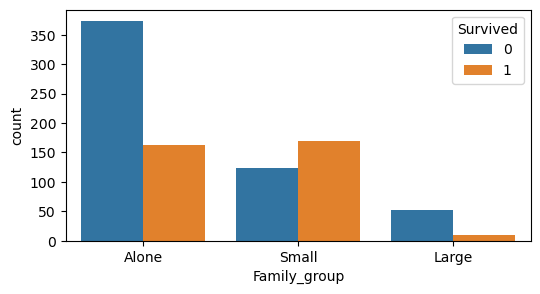

In [36]:
plt.figure(figsize=(6, 3))
sns.countplot(data=train, x='Family_group', hue='Survived')
plt.show()

In [37]:
# 머신러닝에 필요 없는 컬럼 삭제
train.columns
try:
    test.drop(['Name', 'Ticket', 'Family_size'], axis=1, inplace=True)
    train.drop(['Name', 'Ticket', 'Family_size'], axis=1, inplace=True)
except:
    pass
test.info()
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 418 entries, 892 to 1309
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Pclass        418 non-null    int64   
 1   Sex           418 non-null    object  
 2   Age           418 non-null    int64   
 3   SibSp         418 non-null    int64   
 4   Parch         418 non-null    int64   
 5   Fare          418 non-null    float64 
 6   Embarked      418 non-null    object  
 7   Deck          418 non-null    object  
 8   Family_group  418 non-null    category
dtypes: category(1), float64(1), int64(4), object(3)
memory usage: 29.9+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Survived      891 non-null    int64   
 1   Pclass        891 non-null    int64   
 2   Sex           891 non-null    object  
 3   Age          

In [38]:
# 문제와 답 분리
X_train = train.loc[:, 'Pclass':]
y_train = train.loc[:, 'Survived']
X_test = test


In [39]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)

(891, 9)
(891,)
(418, 9)


In [40]:
cate = ['Sex', 'Embarked', 'Deck', 'Family_group']
cate

['Sex', 'Embarked', 'Deck', 'Family_group']

In [41]:
try:
    X_train_oh = pd.get_dummies(X_train[cate])
    X_test_oh = pd.get_dummies(X_test[cate])
except:
    pass

# X_train 병합
X_train = pd.concat([X_train, X_train_oh], axis=1)
X_test = pd.concat([X_test, X_test_oh], axis=1)

# 인코딩 하기 전 문자형 컬럼 삭제
X_train.drop(cate, axis=1, inplace=True)
X_test.drop(cate, axis=1, inplace=True)

In [42]:
print(X_train.columns)
print(X_test.columns)
print(X_train.shape)
print(X_test.shape)

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_female', 'Sex_male',
       'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Deck_A', 'Deck_B', 'Deck_C',
       'Deck_D', 'Deck_E', 'Deck_F', 'Deck_G', 'Deck_M', 'Deck_T',
       'Family_group_Alone', 'Family_group_Small', 'Family_group_Large'],
      dtype='object')
Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_female', 'Sex_male',
       'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Deck_A', 'Deck_B', 'Deck_C',
       'Deck_D', 'Deck_E', 'Deck_F', 'Deck_G', 'Deck_M', 'Family_group_Alone',
       'Family_group_Small', 'Family_group_Large'],
      dtype='object')
(891, 22)
(418, 21)


In [43]:
# Deck_T 컬럼을 X_test에도 넣어보자
X_test['Deck_T'] = 0

In [47]:
# 컬럼 순서 맞추기
X_test = X_test[X_train.columns]
X_test.columns

### 모델 선택 및 학습

In [99]:
# tree 불러오기
from sklearn.tree import DecisionTreeClassifier
# 모델 객체 생성
tree_model = DecisionTreeClassifier()
# 모델 학습
tree_model.fit(X_train, y_train)
# 모델 예측
pre = tree_model.predict(X_test)
# pre

In [53]:
# gender_submission 파일 불러오기 -> Survived 컬럼 예측값으로 변경
result = pd.read_csv('./data/gender_submission.csv')
result['Survived'] = pre
result.to_csv('submisstion01_ldg.csv', index=False)

In [69]:
# 과대적함 키워드를 설정하여 모델 학습 후 예측
# 사전 가지치기
from sklearn.tree import DecisionTreeClassifier
tree_model = DecisionTreeClassifier(max_depth = 5)
tree_model.fit(X_train, y_train)
pre = tree_model.predict(X_test)

In [70]:
result = pd.read_csv('./data/gender_submission.csv')
result['Survived'] = pre
result.to_csv('submisstion04_ldg.csv', index=False)

In [98]:
# 교차검증을 통해 정확도가 몇정도 나올 것이단 걸 예측

from sklearn.model_selection import cross_val_score
import numpy as np

cv_scores = {}
tree_models = {}
pres = {}
results = {}
result = pd.read_csv('./data/gender_submission.csv')

a = range(1, 20)

for i in a:
    # 모델 객체 생성 및 저장
    tree_models[f"tree_model_{i}"] = DecisionTreeClassifier(criterion='entropy', max_depth=i)

for i in a:
    scores = cross_val_score(tree_models[f"tree_model_{i}"], X_train, y_train, cv=5)
    cv_scores[f"tree_model_{i}"] = scores

# 각 모델의 평균 정확도 출력
for i in a:
    print(f"tree_model_{i}: mean accuracy = {np.mean(cv_scores[f'tree_model_{i}']):.4f}")

for i in a:
    # 모델 객체 생성 및 저장
    tree_models[f"tree_model_{i}"].fit(X_train, y_train)
    pres[f"pre_{i}"] = tree_model.predict(X_test)
    result['Survived'] = pres[f"pre_{i}"]
    result.to_csv('./to_csv/submisstion{}_ldg.csv'.format(i), index=False)

tree_model_1: mean accuracy = 0.7867
tree_model_2: mean accuracy = 0.7733
tree_model_3: mean accuracy = 0.8081
tree_model_4: mean accuracy = 0.8048
tree_model_5: mean accuracy = 0.8103
tree_model_6: mean accuracy = 0.7969
tree_model_7: mean accuracy = 0.8036
tree_model_8: mean accuracy = 0.8171
tree_model_9: mean accuracy = 0.8036
tree_model_10: mean accuracy = 0.8126
tree_model_11: mean accuracy = 0.8013
tree_model_12: mean accuracy = 0.7980
tree_model_13: mean accuracy = 0.7957
tree_model_14: mean accuracy = 0.7935
tree_model_15: mean accuracy = 0.8058
tree_model_16: mean accuracy = 0.8014
tree_model_17: mean accuracy = 0.8081
tree_model_18: mean accuracy = 0.7890
tree_model_19: mean accuracy = 0.7901


- 특성 중요도 확인
    - 모델이 선택한 중요한 특성 확인하기


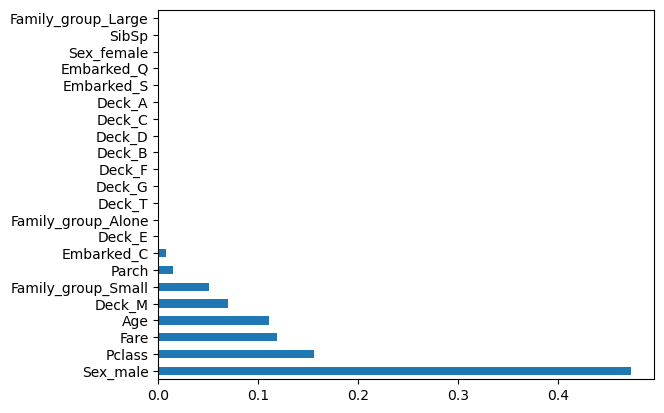

In [95]:
fi = tree_models[f"tree_model_5"].feature_importances_
fi

fi_s = pd.Series(fi, index=X_train.columns)
fi_s.sort_values(ascending=False).plot.barh()
plt.show()